In [1]:
import pandas as pd
import numpy as np
import os
from natsort import natsorted

# Mutations of interest
Find mutations that are "fixed" at the latest sequenced stage of the serial dilution evolution experiments and count how often a given mutation appeared.

### Load mutations into one large dataframe

In [2]:
SOI_SD = natsorted([x for x in os.listdir('./sequencing_results/')])

ref = 'C1_SD_255'
cutoff = 0.0
mutations_all = []
for soi in SOI_SD:
    muts = pd.read_csv('./sequencing_results/{}/mutations_all_{}.csv'.format(soi, cutoff), sep='\t')
    muts = muts.fillna('nan')
    muts['sample'] = soi
    muts['evo_line'] = soi.split('_')[0][0]
    muts['time_generations'] = int(soi.split('_')[-1])
    muts['mutation_id'] = muts['gene'] + ' || ' + muts['annotation'] + ' || ' + muts['position'].astype(str)
    mutations_all.append(muts)


df_mutations_all = pd.concat(mutations_all, axis=0)

### Counts of fixed new mutations relative to C1_SD_255
At the currently last timepoint of the serial dilution evolution.

Determine all mutations and non-synonymous mutations.

Count their repeated occurrence

#### Repeatedly occurring mutations relative to C1_SD_255

In [3]:
evo_lines = df_mutations_all[df_mutations_all['sample'] != ref]['evo_line'].unique()

latest_timepoints = {x:df_mutations_all[df_mutations_all['evo_line'] == x]['time_generations'].max() for x in evo_lines}


frequency_cutoff = 0.6
frequency_cutoff_ref = 0.1  # all mutations present at >=10% in C1_SD_255 go to fixation shortly after in all replicate serial dilution lines
ref_fixed_muts = df_mutations_all[(df_mutations_all['sample'] == ref) & (df_mutations_all['freq'] >= frequency_cutoff_ref)]['mutation_id'] # list of mutations that were already fixed in C1_SD_255

# fixed mutations at the last timepoint
df_new_fixed = df_mutations_all[~(df_mutations_all['mutation_id'].isin(ref_fixed_muts)) & (df_mutations_all['freq'] >= frequency_cutoff)]
df_new_fixed_lt = pd.concat([df_new_fixed[(df_new_fixed['evo_line'] == el) & (df_new_fixed['time_generations'] == latest_timepoints[el])] for el in latest_timepoints])
df_new_fixed_lt_ns = df_new_fixed_lt[df_new_fixed_lt['WT_aa'] != df_new_fixed_lt['mut_aa']]

# new mutations and the number of occurences
new_muts = df_new_fixed_lt.groupby('mutation_id').size().sort_values(ascending=False)
new_muts_ns = df_new_fixed_lt_ns.groupby('mutation_id').size().sort_values(ascending=False)

new_muts_mo = new_muts[new_muts>1]          # mutations with more than one occurrence across evo lines
new_muts_ns_mo = new_muts_ns[new_muts_ns>1] # mutations with more than one occurrence across evo lines
new_muts_mo.to_csv('./multiply_occuring_mutations_fco_{}.csv'.format(frequency_cutoff), sep='\t')
new_muts_ns_mo.to_csv('./multiply_occuring_mutations_ns_fco_{}.csv'.format(frequency_cutoff), sep='\t')

# Multiply hit genes relative to C1_SD_255

In [4]:
new_muts_gene = df_new_fixed_lt.groupby('gene').size().sort_values(ascending=False)
new_muts_gene_ns = df_new_fixed_lt_ns.groupby('gene').size().sort_values(ascending=False)

new_muts_gene_filtered = new_muts_gene[new_muts_gene > 2]
new_muts_gene_ns_filtered = new_muts_gene_ns[new_muts_gene_ns > 2]

new_muts_gene_mo = df_new_fixed_lt[df_new_fixed_lt['gene'].isin(new_muts_gene_filtered.index)]['mutation_id'].unique()                  # mutations with more than one occurrence across evo lines
new_muts_gene_ns_mo = df_new_fixed_lt_ns[df_new_fixed_lt_ns['gene'].isin(new_muts_gene_ns_filtered.index)]['mutation_id'].unique()      # mutations with more than one occurrence across evo lines



In [5]:
# avg number of new mutations above frequency cutoff
df_new_fixed_lt_ns.groupby('evo_line').size().mean(), df_new_fixed_lt_ns.groupby('evo_line').size().std()

(313.75, 53.2126238155321)

In [6]:
new_muts_gene.to_csv('./multiply_hit_genes_fco_{}.csv'.format(frequency_cutoff), sep='\t')
new_muts_gene_ns.to_csv('./multiply_hit_genes_ns_fco_{}.csv'.format(frequency_cutoff), sep='\t')
df_new_fixed_lt_ns.to_excel('./all_new_ns_mutations_fco_{}.xlsx'.format(frequency_cutoff), index=False)

#### Venn diagram of genes hit by non-synonymous mutations by replicate line

In [7]:
def evo_line_counts(grp):
    # print(grp)
    el = grp['evo_line'].unique().tolist()
    el_str = '_'.join(el)

    size = len(el)
    dict_out = {'mutation_id_{}'.format(i): [grp['mutation_id'].unique()[i]] for i in range(grp['mutation_id'].unique().shape[0])}
    dict_out['evo_line_indicator'] = [el_str]
    dict_out['no_present'] = [size]
    # print(mi)
    return pd.DataFrame(dict_out) 



df_new_fixed_lt_ns_counts = df_new_fixed_lt_ns.groupby(['gene'])[['evo_line', 'mutation_id']].apply(evo_line_counts)
df_new_fixed_lt_ns_counts = df_new_fixed_lt_ns_counts.droplevel(1)
df_new_fixed_lt_ns_counts = df_new_fixed_lt_ns_counts.reindex(sorted(df_new_fixed_lt_ns_counts.columns), axis=1)

df_new_fixed_lt_ns_counts = df_new_fixed_lt_ns_counts.sort_values('no_present', ascending=False)
df_new_fixed_lt_ns_counts.to_excel('all_new_ns_mutations_fco_{}_by_multiple_occurence.xlsx'.format(frequency_cutoff))



In [8]:
mutated_genes = df_new_fixed_lt_ns['gene'].unique()

venn = {}
for m in mutated_genes:
    df_m = df_new_fixed_lt_ns[df_new_fixed_lt_ns['gene'] == m]


mutated_genes_el = df_new_fixed_lt_ns.groupby('evo_line')['gene'].unique().to_list()
mutated_genes_el = [set(x) for x in mutated_genes_el]


In [9]:
def polar_to_cartesian(alpha, r):
    x = np.cos(alpha) * r + 0.5
    y = np.sin(alpha) * r + 0.25
    return x, y

c:\Users\mreiter\AppData\Local\miniforge-pypy3\envs\mybase\Lib\site-packages\venn\_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
c:\Users\mreiter\AppData\Local\miniforge-pypy3\envs\mybase\Lib\site-packages\venn\_backwards_compatibility.py:30: UserWarning: `venn4()` is retained for backwards compatibility; use `venn()` instead
  warn((
C:\Users\mreiter\AppData\Local\Temp\ipykernel_27040\3432635382.py:146: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


HPS
fepA
rhlB
pykF
pykA
ppsR
gnd
–


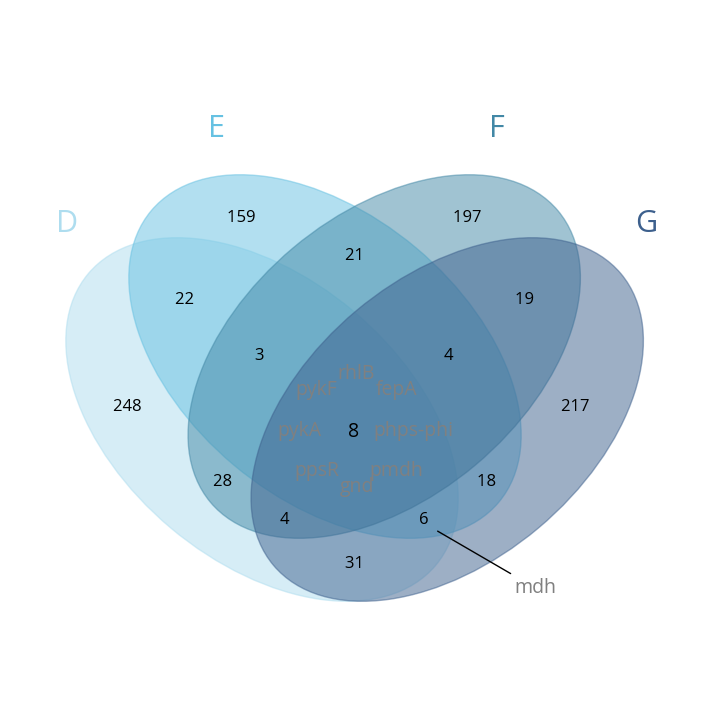

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import venn

labels = venn.get_labels(mutated_genes_el, fill=['number'])
fig, ax = venn.venn4(labels, names=df_new_fixed_lt_ns['evo_line'].unique())


fm = matplotlib.font_manager
fm._get_fontconfig_fonts.cache_clear()
# change face colors
n = 255.0

colors = [ 
            (174/n, 221/n, 239/n, 1),
            (102/n, 193/n, 226/n, 1),
            (66/n, 136/n, 166/n, 1),
            (61/n, 96/n, 141/n, 1)
        ]



colors_transparent = [ 
            (174/n, 221/n, 239/n, 0.5),
            (102/n, 193/n, 226/n, 0.5),
            (66/n, 136/n, 166/n, 0.5),
            (61/n, 96/n, 141/n, 0.5)
            ]

ax.patches[0].set_facecolor(colors_transparent[0])
ax.patches[0].set_edgecolor(colors_transparent[0])


ax.patches[1].set_facecolor(colors_transparent[1])
ax.patches[1].set_edgecolor(colors_transparent[1])

ax.patches[2].set_facecolor(colors_transparent[2])
ax.patches[2].set_edgecolor(colors_transparent[2])

ax.patches[3].set_facecolor(colors_transparent[3])
ax.patches[3].set_edgecolor(colors_transparent[3])

# change font in face annotations
[x.set_font('Open Sans') for x in ax.texts]
[x.set_fontsize(12) for x in ax.texts]

# format the intersect all differently
ax.texts[-1].set_fontweight('bold')
ax.texts[-1].set_fontsize(14)

# add annotations
rep_D_alpha = 3 * np.pi/4
rep_D_text = 'D'
r = 0.65
rep_D_x, rep_D_y = polar_to_cartesian(rep_D_alpha, r)


ax.text(
    rep_D_x, rep_D_y, rep_D_text,
    horizontalalignment='center',
    verticalalignment='center',
    font = 'Open Sans',
    weight = 'bold',
    fontsize = 22,
    color = colors[0])

rep_E_alpha =  np.pi/2 + 0.35
rep_E_text = 'E'
rep_E_x, rep_E_y = polar_to_cartesian(rep_E_alpha, r)
ax.text(
    rep_E_x, rep_E_y, rep_E_text,
    horizontalalignment='center',
    verticalalignment='center',
    font = 'Open Sans',
    weight = 'bold',
    fontsize = 22,
    color = colors[1])

rep_F_alpha =  np.pi/2 - 0.35
rep_F_text = 'F'
rep_F_x, rep_F_y = polar_to_cartesian(rep_F_alpha, r)
ax.text(
    rep_F_x, rep_F_y, rep_F_text,
    horizontalalignment='center',
    verticalalignment='center',
    font = 'Open Sans',
    # weight = '',
    fontsize = 22,
    color = colors[2])

rep_G_alpha = np.pi/4
rep_G_text = 'G'
rep_G_x, rep_G_y = polar_to_cartesian(rep_G_alpha, r)
ax.text(
    rep_G_x, rep_G_y, rep_G_text,
    horizontalalignment='center',
    verticalalignment='center',
    font = 'Open Sans',
    weight = 'bold',
    fontsize = 22,
    color = colors[3])
ax.get_legend().remove()

# add gene names of genes that were hit 4 times
genes = df_new_fixed_lt_ns_counts[df_new_fixed_lt_ns_counts['no_present'] == 4].index
for i, g in enumerate(genes):
    print(g)
    r = 0.09
    alpha = 2 * i* np.pi / genes.shape[0]
    x, y = polar_to_cartesian(alpha, r)
    y = y + 0.1325

    style = 'normal'
    if g == 'HPS':
        text = 'phps-phi'
        style = 'normal'
    elif g == '–':
        text = 'pmdh'
        style = 'normal'
    else:
        text = g
    ax.text(
            x, y, text,
            horizontalalignment='center',
            verticalalignment='center',
            font = 'Open Sans',
            style = style,
            fontsize = 14,
            color = 'grey',
    )


# add mdh annotation
arpr = {"arrowstyle": "-",}
        # "connectionstyle": "arc,angleA=-90,armA=20,angleB=90,armB=20,rad=10"}
ax.annotate('mdh', (0.625, 0.225), (0.75, 0.125),
            font = 'Open Sans',
            fontsize = 14,
            style = 'normal', 
            color = 'grey',
            arrowprops=arpr
            )


# show/save fig
fig.show()
plt.rcParams['pdf.fonttype'] = 42  # make text editable in pdf
fig.savefig('Figure 2c.pdf', format='pdf')

